In [1]:
# Import required packages
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

2022-10-30 22:39:24.747530: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [2]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


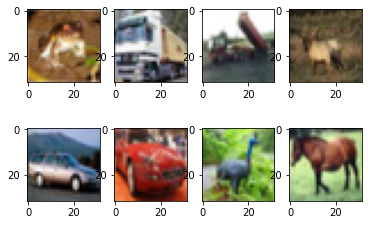

In [9]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [10]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [12]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [13]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

Clean labels:
 frog truck truck  deer   car   car  bird horse
Predicted baseline labels:
 frog  ship truck  frog  ship   cat  deer horse


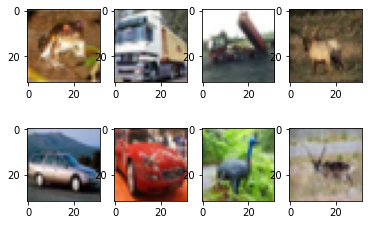

In [80]:
fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
print('Predicted baseline labels:')
print(' '.join('%5s' % classes[int(baseline_model(imgs[j])[0])] for j in range(8)))

### 2.2. Model I

In [16]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.applications import vgg16, vgg19, resnet, inception_v3
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from keras.utils import to_categorical
from livelossplot.inputs.keras import PlotLossesCallback
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [4]:
# Split the data into training set (75%) and test set (25%)
x_train, x_test, y_train, y_test = train_test_split(imgs, noisy_labels, test_size = 0.25, random_state = 4)

#### Candidate Model 1: VGG-16

In [18]:
# Preprocess input
x_train_vgg16 = vgg16.preprocess_input(x_train) 
x_test_vgg16 = vgg16.preprocess_input(x_test)

# Transform labels to correct format
y_train_vec = to_categorical(y_train, num_classes=10)
y_test_vec = to_categorical(y_test, num_classes=10)

In [163]:
# Load VGG16 model
def create_model_vgg16(input_shape, n_classes, optimizer, fine_tune):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training
    fine_tune: int - The number of pre-trained layers to unfreeze
    """
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    conv_base = vgg16.VGG16(include_top=False,
                            weights='imagenet', 
                            input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    # If the arg fine_tune is set to 0, all pre-trained layers will be frozen and left un-trainable.
    # Otherwise, the last n layers will be made available for training.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers) 
    # by grabbing the conv_base outputs and flattening them.
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    # Dropout = 0.2 means one in five inputs will be randomly excluded from each update cycle.
    top_model = conv_base.output
    top_model = Flatten()(top_model)
    top_model = Dense(n_classes*8, activation='relu')(top_model)
    top_model = Dense(n_classes*4, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model) 
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


input_shape = (32, 32, 3)
n_classes=10
optim = Adam(learning_rate=0.001) 
vgg16_model = create_model_vgg16(input_shape, n_classes, optim, fine_tune = 2)

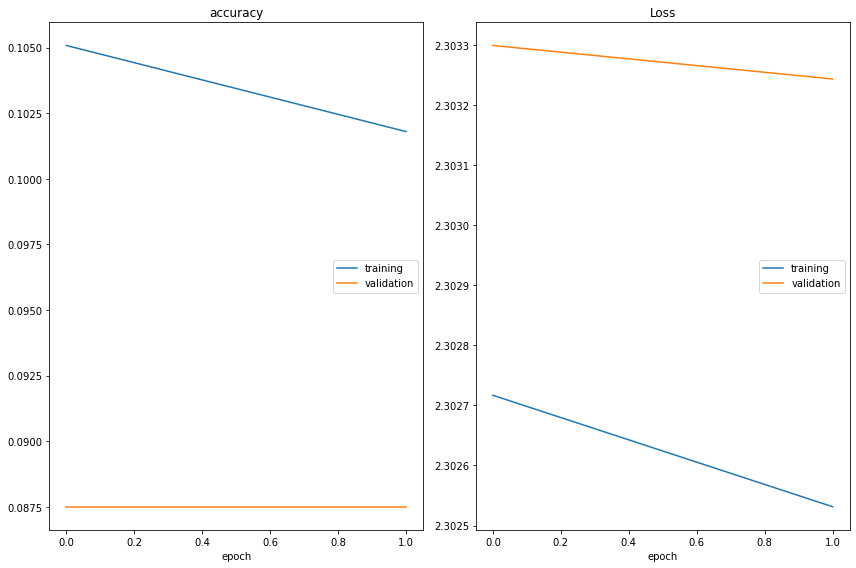

accuracy
	training         	 (min:    0.102, max:    0.105, cur:    0.102)
	validation       	 (min:    0.087, max:    0.087, cur:    0.087)
Loss
	training         	 (min:    2.303, max:    2.303, cur:    2.303)
	validation       	 (min:    2.303, max:    2.303, cur:    2.303)
100/100 [==============================] - 133s 1s/step - loss: 2.3025 - accuracy: 0.1018 - val_loss: 2.3032 - val_accuracy: 0.0875


In [166]:
# Train the VGG16 model
# ModelCheckpoint callback is used to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.
# EarlyStopping stops training when a monitored metric has stopped improving.
# Batch size defines the number of samples to work through before updating the internal model parameters.
# The number of epochs defines the number times that the learning algorithm will work through the entire training dataset.
vgg16_checkpoint = ModelCheckpoint(filepath='vgg16.weights.best.hdf5', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
plot_loss = PlotLossesCallback()
vgg16_fit = vgg16_model.fit(x_train_vgg16, 
                            y_train_vec,
                            batch_size=128, # Mini-batch gradient descent
                            epochs=2,# 20
                            steps_per_epoch=100, #1000
                            validation_split=0.2, 
                            validation_steps=20, #200
                            callbacks=[vgg16_checkpoint, early_stop, plot_loss],
                            verbose=1)

In [211]:
def vgg16_model1(image):
    '''
    This is the VGG16 predictive model that takes in the image and returns a label prediction
    '''
    img_mtx = vgg16.preprocess_input(image[np.newaxis, :])
    vgg16_model.load_weights('vgg16.weights.best.hdf5')
    vgg16_preds = vgg16_model.predict(img_mtx)
    vgg16_pred_classes = np.argmax(vgg16_preds, axis=1)
    return int(vgg16_pred_classes[0])

In [213]:
# Test the prediction
vgg16_model1(imgs[1])
# vgg16_acc = accuracy_score(y_test_vec, vgg16_pred_classes)
# print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

1/1 [==============================] - 0s 37ms/step


4

#### Candidate Model 2: VGG-19

In [214]:
# Preprocess input
x_train_vgg19 = vgg19.preprocess_input(x_train) 
x_test_vgg19 = vgg19.preprocess_input(x_test)

In [215]:
# Load VGG19 model
def create_model_vgg19(input_shape, n_classes, optimizer, fine_tune):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
               If set to 0, all pretrained layers will freeze during training
    """
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = vgg19.VGG19(include_top=False,
                            weights='imagenet', 
                            input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    # If the arg fine_tune is set to 0, all pre-trained layers will be frozen and left un-trainable.
    # Otherwise, the last n layers will be made available for training.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers) 
    # by grabbing the conv_base outputs and flattening them.
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten()(top_model)
    top_model = Dense(n_classes*8, activation='relu')(top_model)
    top_model = Dense(n_classes*4, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model) 
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


input_shape = (32, 32, 3)
n_classes=10
optim = Adam(learning_rate=0.001) 
vgg19_model = create_model_vgg19(input_shape, n_classes, optim, fine_tune = 2)

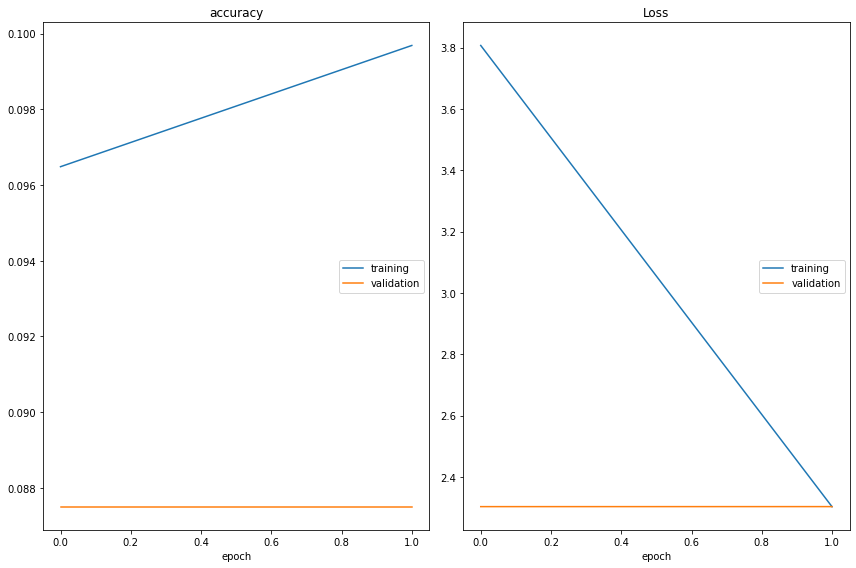

accuracy
	training         	 (min:    0.096, max:    0.100, cur:    0.100)
	validation       	 (min:    0.087, max:    0.087, cur:    0.087)
Loss
	training         	 (min:    2.303, max:    3.807, cur:    2.303)
	validation       	 (min:    2.303, max:    2.303, cur:    2.303)
100/100 [==============================] - 178s 2s/step - loss: 2.3025 - accuracy: 0.0997 - val_loss: 2.3029 - val_accuracy: 0.0875


In [216]:
# Train the VGG19 model
# ModelCheckpoint callback is used to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.
# EarlyStopping stops training when a monitored metric has stopped improving.
# Batch size defines the number of samples to work through before updating the internal model parameters.
# The number of epochs defines the number times that the learning algorithm will work through the entire training dataset.
vgg19_checkpoint = ModelCheckpoint(filepath='vgg19.weights.best.hdf5', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
plot_loss = PlotLossesCallback()
vgg19_fit = vgg19_model.fit(x_train_vgg19, 
                            y_train_vec,
                            batch_size=128, # Mini-batch gradient descent
                            epochs=2,# 20
                            steps_per_epoch=100, #1000
                            validation_split=0.2, 
                            validation_steps=20, #200
                            callbacks=[vgg19_checkpoint, early_stop, plot_loss],
                            verbose=1)

In [217]:
def vgg19_model1(image):
    '''
    This is the VGG16 predictive model that takes in the image and returns a label prediction
    '''
    img_mtx = vgg19.preprocess_input(image[np.newaxis, :])
    vgg19_model.load_weights('vgg19.weights.best.hdf5')
    vgg19_preds = vgg19_model.predict(img_mtx)
    vgg19_pred_classes = np.argmax(vgg19_preds, axis=1)
    return int(vgg19_pred_classes[0])

In [219]:
# Test the prediction
vgg19_model1(imgs[1])

1/1 [==============================] - 0s 302ms/step


4

#### Candidate Model 3: ResNet Approach

In [220]:
# Preprocess input
x_train_resnet = resnet.preprocess_input(x_train) 
x_test_resnet = resnet.preprocess_input(x_test)

In [221]:
# Load ResNet model
def create_model_resnet(input_shape, n_classes, optimizer, fine_tune):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
               If set to 0, all pretrained layers will freeze during training
    """
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = resnet.ResNet50(include_top=False,
                                weights='imagenet', 
                                input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    # If the arg fine_tune is set to 0, all pre-trained layers will be frozen and left un-trainable.
    # Otherwise, the last n layers will be made available for training.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers) 
    # by grabbing the conv_base outputs and flattening them.
    # This is 'bootstrapping' a new top_model onto the pretrained layers.   
    top_model = conv_base.output
    top_model = Flatten()(top_model)
    top_model = Dense(n_classes*8, activation='relu')(top_model)
    top_model = Dense(n_classes*4, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model) 
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


input_shape = (32, 32, 3)
n_classes=10
optim = Adam(learning_rate=0.001) 
resnet_model = create_model_resnet(input_shape, n_classes, optim, fine_tune = 2)

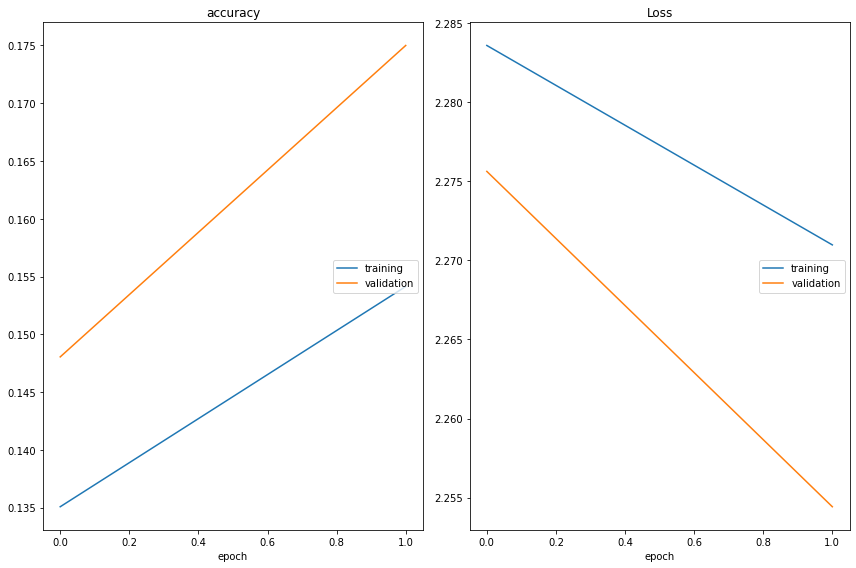

accuracy
	training         	 (min:    0.135, max:    0.154, cur:    0.154)
	validation       	 (min:    0.148, max:    0.175, cur:    0.175)
Loss
	training         	 (min:    2.271, max:    2.284, cur:    2.271)
	validation       	 (min:    2.254, max:    2.276, cur:    2.254)
100/100 [==============================] - 43s 430ms/step - loss: 2.2710 - accuracy: 0.1541 - val_loss: 2.2544 - val_accuracy: 0.1750


In [227]:
# Train the ResNet model
# ModelCheckpoint callback is used to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.
# EarlyStopping stops training when a monitored metric has stopped improving.
# Batch size defines the number of samples to work through before updating the internal model parameters.
# The number of epochs defines the number times that the learning algorithm will work through the entire training dataset.
resnet_checkpoint = ModelCheckpoint(filepath='resnet.weights.best.hdf5', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
plot_loss = PlotLossesCallback()
resnet_fit = resnet_model.fit(x_train_resnet, 
                            y_train_vec,
                            batch_size=128, # Mini-batch gradient descent
                            epochs=2,# 20
                            steps_per_epoch=100, #1000
                            validation_split=0.2, 
                            validation_steps=20, #200
                            callbacks=[resnet_checkpoint, early_stop, plot_loss],
                            verbose=1)

In [228]:
def resnet_model1(image):
    '''
    This is the VGG16 predictive model that takes in the image and returns a label prediction
    '''
    img_mtx = resnet.preprocess_input(image[np.newaxis, :])
    resnet_model.load_weights('resnet.weights.best.hdf5')
    resnet_preds = resnet_model.predict(img_mtx)
    resnet_pred_classes = np.argmax(resnet_preds, axis=1)
    return int(resnet_pred_classes[0])

In [229]:
# Test the prediction
resnet_model1(imgs[1])

1/1 [==============================] - 1s 1s/step


8

#### Candidate Model 4: Inception

In [28]:
# Preprocess input
x_train_incep = inception_v3.preprocess_input(tf.image.resize(x_train,(75,75)).numpy()) 
x_test_incep = inception_v3.preprocess_input(tf.image.resize(x_test,(75,75)).numpy())

In [23]:
# Load InceptionV3 model
def create_model_incep(input_shape, n_classes, optimizer, fine_tune):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
               If set to 0, all pretrained layers will freeze during training
    """
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = inception_v3.InceptionV3(include_top=False,
                                weights='imagenet', 
                                input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    # If the arg fine_tune is set to 0, all pre-trained layers will be frozen and left un-trainable.
    # Otherwise, the last n layers will be made available for training.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers) 
    # by grabbing the conv_base outputs and flattening them.
    # This is 'bootstrapping' a new top_model onto the pretrained layers.   
    top_model = conv_base.output
    top_model = Flatten()(top_model)
    top_model = Dense(n_classes*8, activation='relu')(top_model)
    top_model = Dense(n_classes*4, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model) 
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


input_shape = (75, 75, 3)
n_classes=10
optim = Adam(learning_rate=0.0001) 
incep_model = create_model_incep(input_shape, n_classes, optim, fine_tune = 2)

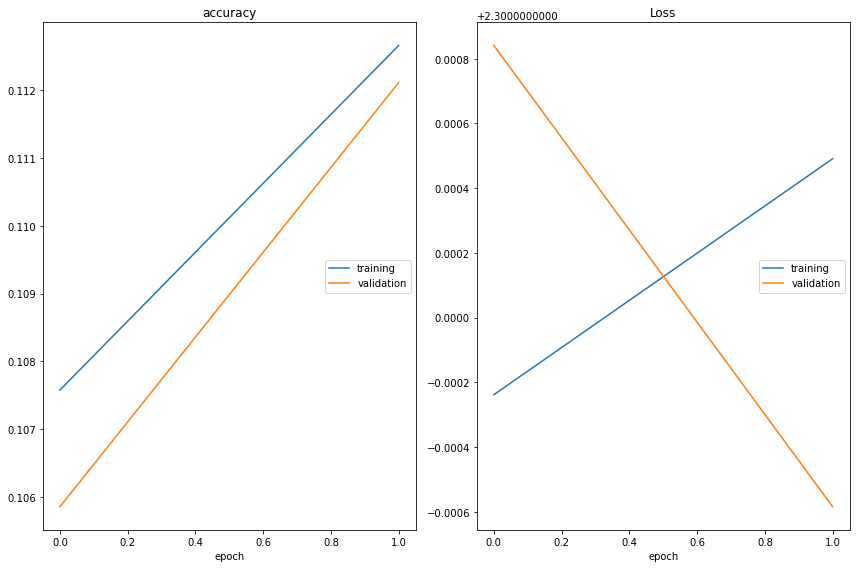

accuracy
	training         	 (min:    0.108, max:    0.113, cur:    0.113)
	validation       	 (min:    0.106, max:    0.112, cur:    0.112)
Loss
	training         	 (min:    2.300, max:    2.300, cur:    2.300)
	validation       	 (min:    2.299, max:    2.301, cur:    2.299)
100/100 [==============================] - 104s 1s/step - loss: 2.3005 - accuracy: 0.1127 - val_loss: 2.2994 - val_accuracy: 0.1121


In [29]:
# Train the InceptionV3 model
# ModelCheckpoint callback is used to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.
# EarlyStopping stops training when a monitored metric has stopped improving.
# Batch size defines the number of samples to work through before updating the internal model parameters.
# The number of epochs defines the number times that the learning algorithm will work through the entire training dataset.
incep_checkpoint = ModelCheckpoint(filepath='incep.weights.best.hdf5', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
plot_loss = PlotLossesCallback()
incep_fit = incep_model.fit(x_train_incep, 
                            y_train_vec,
                            batch_size=128, # Mini-batch gradient descent
                            epochs=2,# 20
                            steps_per_epoch=100, #1000
                            validation_split=0.2, 
                            validation_steps=20, #200
                            callbacks=[incep_checkpoint, early_stop, plot_loss],
                            verbose=1)

In [30]:
def incep_model1(image):
    '''
    This is the InceptionV3 predictive model that takes in the image and returns a label prediction
    '''
    img_mtx = inception_v3.preprocess_input(tf.image.resize(image[np.newaxis, :],(75,75)).numpy()) 
    incep_model.load_weights('incep.weights.best.hdf5')
    incep_preds = incep_model.predict(img_mtx)
    incep_pred_classes = np.argmax(incep_preds, axis=1)
    return int(incep_pred_classes[0])

In [31]:
# Test the prediction
incep_model1(imgs[1])

1/1 [==============================] - 2s 2s/step


5

#### Best Model for Model I

In [ ]:
def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...

### 2.3. Model II

In [ ]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# write your code here...

def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...

In [8]:
import os
from inception import maybe_download, Inception, transfer_values_cache

model = Inception()

output_path = "inception/"
inception_train_output_path = os.path.join(output_path, 'inception_cifar10_train.pkl')

inception_train_output = transfer_values_cache(cache_path=inception_train_output_path,
                                               images=imgs,
                                               model=model)

- Processing image:      1 / 50000

2022-10-26 03:20:38.253637: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


- Processing image:  50000 / 50000
- Data saved to cache-file: inception/inception_cifar10_train.pkl


In [8]:
inception_train_output = pd.read_pickle('inception/inception_cifar10_train.pkl')
inception_train_output
# inception_train_output.shape
# clean_labels.shape

array([[2.1053407e-01, 1.5321362e-01, 3.9882633e-01, ..., 4.0137359e-01,
        2.0353939e-01, 3.7826568e-01],
       [9.8467781e-04, 6.7002630e-01, 3.3626223e-01, ..., 4.7811350e-01,
        3.2780012e-01, 1.7593765e+00],
       [1.1270681e-02, 1.5620130e-01, 2.3900677e-01, ..., 9.0337402e-01,
        2.0110352e-01, 4.6615061e-01],
       ...,
       [7.0134535e-02, 9.8179698e-02, 4.9430177e-01, ..., 5.8158237e-02,
        8.4625280e-01, 6.9151586e-01],
       [7.8753345e-03, 3.0278200e-01, 4.6101239e-01, ..., 1.6287608e-02,
        6.4677322e-01, 6.0698915e-01],
       [2.5536042e-01, 3.8889664e-01, 1.7252818e-01, ..., 4.4581279e-01,
        9.2975199e-02, 8.0242157e-02]], dtype=float32)

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [ ]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [ ]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.